In [1]:
import os
import torch
import cv2
import cPickle
import numpy as np
import errno
import glob

from faster_rcnn import network
from faster_rcnn.faster_rcnn_x import FasterRCNN, FasterRCNN_x
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir
from faster_rcnn.datasets.voc_eval import voc_eval
from faster_rcnn.datasets.jg_voc_eval import voc_eval as jg_voc_eval
import pickle

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline
from itertools import cycle
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = ['red','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','blue','green','darkyellow']
lw = 2


In [3]:
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'

## INOUT

In [5]:
pathBasic='/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_inout_exp/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_inout.yml'
# load config

Filter={'inout_test_Depth':'Depth',
        'inout_test_Cube':'Cube',
        'inout_test_Jet':'Jet',
        }

Filter={'inout_test_Images':'RGB',
        'inout_test_Depth':'Depth',
        'inout_u_train_on_test_rgbd_10000':'Fusion U',
        'inout_u_train_on_test_rgbd_10000_blackout':'Fusion U *',
        'inout_x_train_on_test_rgbd_10000':'Fusion X',
        'inout_x_train_on_test_rgbd_10000_blackout':'Fusion X *',
        'inout_y_train_on_inout_rgbd_100000':'Fusion Y',
        'inout_y_train_on_inout_rgbd_100000_blackout':'Fusion Y *'}
        



cfg_from_file(cfg_file)

imdb_test_name_0 = 'inout_test_Images'
imdb_0 = get_imdb(imdb_test_name_0)
annopath = os.path.join(imdb_0._data_path,'Annotations_pv', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'ImageSets',imdb_0._image_set + '.txt')


allDetectionFiles=sorted(glob.glob(pathBasic+"*/*.pkl"))

myList={}
for i,detection_file in enumerate(allDetectionFiles):
    if 'jg_t' in detection_file:
        continue
    
        
    name = os.path.split(detection_file)[-1][:-4]
    folder=os.path.split(os.path.split(detection_file)[0])[-1]
    if folder not in Filter.keys():
        continue
    
    

    myList[Filter[folder]]={'path':detection_file,
                  'name':Filter[folder],
                  'results':{}}
    print folder
print 'Done.'
# myList

<bound method inout.default_roidb of <faster_rcnn.datasets.inout.inout object at 0x7f30b441c090>>
Remove empty annotations:  Done. [ 38 removed]
inout_test_Depth
inout_test_Images
inout_u_train_on_test_rgbd_10000
inout_u_train_on_test_rgbd_10000_blackout
inout_x_train_on_test_rgbd_10000
inout_x_train_on_test_rgbd_10000_blackout
inout_y_train_on_inout_rgbd_100000
inout_y_train_on_inout_rgbd_100000_blackout


## ONERA.ROOM

In [ ]:
pathBasic='/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_oneraroom_exp/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_oneraroom.yml'
# load config

Filter={'oneraroom_easy_rgb':'RGB',
        'oneraroom_easy_depth_8bits':'Depth',
        'inout_u_train_on_oneraroom_easy_rgbd_10000':'Fusion U',
        'inout_u_train_on_oneraroom_easy_rgbd_10000_blackout':'Fusion U *',
        'inout_x_train_on_oneraroom_easy_rgbd_10000':'Fusion X',
        'inout_x_train_on_oneraroom_easy_rgbd_10000_blackout':'Fusion X *',
        'inout_y_train_on_oneraroom_easy_rgbd_100000':'Fusion Y',
        'inout_y_train_on_oneraroom_easy_rgbd_100000_blackout':'Fusion Y *'}
        
# Filter={'oneraroom_easy_rgb':'RGB'}



cfg_from_file(cfg_file)

imdb_test_name_0 = 'oneraroom_easy_rgb'
# imdb_0 = get_imdb(imdb_test_name_0)
annopath = os.path.join(imdb_0._data_path,'annotations', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'sets',imdb_0._image_set + '.txt')


allDetectionFiles=sorted(glob.glob(pathBasic+"*/*.pkl"))

myList={}
for i,detection_file in enumerate(allDetectionFiles):
    if 'jg_t' in detection_file:
        continue
    
        
    name = os.path.split(detection_file)[-1][:-4]
    folder=os.path.split(os.path.split(detection_file)[0])[-1]
    if folder not in Filter.keys():
        continue
    
    

    myList[Filter[folder]]={'path':detection_file,
                  'name':Filter[folder],
                  'results':{}}
    print folder

# myList

In [6]:
cachedir = os.path.join(imdb_0._devkit_path, 'faster_rcnn', 'annotations_cache')
use_07_metric = False
if not os.path.isdir(pathBasic):
    os.mkdir(pathBasic)
cls='person'
for key in myList:
    print key
    all_boxes = pickle.load( open( myList[key]['path'], "rb" ) )
    for cls_ind, cls in enumerate(imdb_0.classes):
        if cls == '__background__':
            continue
        filename = imdb_0._get_voc_results_file_template().format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(imdb_0.image_index):
                dets = all_boxes[cls_ind][im_ind]
                if len(dets) == 0:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in xrange(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                        format(index, dets[k, -1],              # filename(stem), score
                               dets[k, 0] + 1, dets[k, 1] + 1,  # x1, y1, x2, y2
                               dets[k, 2] + 1, dets[k, 3] + 1))
    
    
    for i, cls in enumerate(imdb_0._classes):
        if cls == '__background__':
            continue
        filename = imdb_0._get_voc_results_file_template().format(cls)
        rec, prec, ap, tp, fp, iou, npos, img_relative_tp = jg_voc_eval(filename, annopath, imagesetfile, 
                                                                        cls, cachedir,ovthresh=0.5, 
                                                                        use_07_metric = use_07_metric)
        myList[key]['results'][cls]={'rec':rec,'prec':prec,'ap':ap,'tp':tp,'fp':fp,'iou':iou,
                                     'npos':npos,'img_relative_tp':img_relative_tp}


print 'Done.'

Fusion X
Fusion Y
Fusion U
Fusion X *
RGB
Depth
Fusion Y *
Fusion U *
Done.


In [7]:
order=['RGB', 'Depth', 'Fusion U', 'Fusion X', 'Fusion Y', 'Fusion U *', 'Fusion X *', 'Fusion Y *']

Fusion Y * O detection


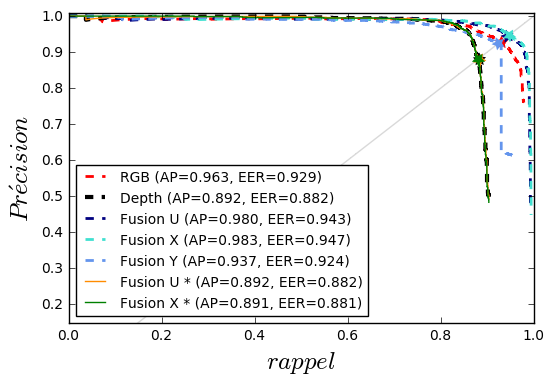

In [8]:
colors = ['red','black','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','blue','green','darkyellow']
colors = ['red','black','navy', 'turquoise', 'cornflowerblue', 'darkorange', 'green','blue','green','darkyellow']

plt.clf()
i=0

x = np.linspace(0, 1, num=100, endpoint=True)
y = np.linspace(0, 1, num=100, endpoint=True)
plt.plot(x, y,  color='0.85',markersize=1,marker=',') 

for key in order:
    if key not in myList.keys():
        continue
    if len(myList[key]['results']['person']['rec'])==0:
        print key,'O detection'
        continue
        
    idx = np.argwhere(np.diff(np.sign(myList[key]['results']['person']['rec'] - myList[key]['results']['person']['prec'])) != 0).reshape(-1) + 0
    EER = myList[key]['results']['person']['rec'][idx]
    max_id_EER=np.argmax(EER)
    idx=idx[max_id_EER]
    EER = myList[key]['results']['person']['rec'][idx]
    
    
    nd = len(myList[key]['results']['person']['tp'])
    TP = sum(myList[key]['results']['person']['tp'])
    FP = sum(myList[key]['results']['person']['fp'])
    not0iou=[iou for iou in myList[key]['results']['person']['iou'] if iou!=0]
    IoU = np.mean(not0iou)
    precision = TP/(nd)
    recall = TP/npos
    F1=2*precision*recall/(precision+recall)
    
    myList[key]['results']['person']['meanIoU']=IoU
    myList[key]['results']['person']['precision']=precision
    myList[key]['results']['person']['recall']=recall
    myList[key]['results']['person']['F1']=F1
    myList[key]['results']['person']['EER']=EER
    myList[key]['results']['person']['TP']=int(TP)
    myList[key]['results']['person']['FP']=int(FP)
    
    
    plt.plot(myList[key]['results']['person']['rec'][idx], myList[key]['results']['person']['prec'][idx],  
             color=colors[i%len(colors)],markeredgecolor = 'none',markersize=10,marker=(5, 1, i**3*1.5))   
    marker=None
    lw=2
    ls='--'
    if '*' in key:
        lw=1
        ls=None
    if 'Depth' in key:
        lw=3
#         marker='<'
        
    plt.plot(myList[key]['results']['person']['rec'], myList[key]['results']['person']['prec'],
             color=colors[i%len(colors)], lw=lw, ls=ls,marker=marker,
             label=myList[key]['name']+' (AP={:.3f}, EER={:.3f})'.format(myList[key]['results']['person']['ap'],
                                                                         EER))
        
    i+=1
#     +'(AP = {1:0.2f})'.format(myList[key]['results']['person']['ap'])

plt.xlim([0.0, 1.0])
plt.ylim([0.15, 1.01])
plt.xlabel('$rappel$',fontsize=18)
plt.ylabel(r'$Pr\acute{e}cision$',fontsize=18)

   
    
# plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower left",prop={'size':10})

# plt.plot([0.5], [0.8], color='color',marker='o')


plt.show()

## Affichages des indices de mesure de qualité

In [9]:
for key in order:
    if key not in myList.keys():
        continue
    if len(myList[key]['results']['person']['rec'])==0:
        print key,'O detection'
        continue
#     print 100*'_'
        
        
#     print key+' :IoU={:.3f}, Precision={:.3f},Rappel={:.3f},F1={:.3f},EER={:.3f},TP={:d},FP={:d}'\
#     .format(myList[key]['results']['person']['meanIoU'], 
#             myList[key]['results']['person']['precision'],
#             myList[key]['results']['person']['recall'],
#             myList[key]['results']['person']['F1'],
#             myList[key]['results']['person']['EER'], 
#             myList[key]['results']['person']['TP'],
#             myList[key]['results']['person']['FP'])
    print key+'                        & \\textit{{\\sout{{RGB}}-D}}       & {:.3f}/{:.3f}         & {:.3f}            & {:.3f}            &  {:.3f}                  & {:.3f}          \\\\'\
    .format(myList[key]['results']['person']['precision'], 
            myList[key]['results']['person']['recall'],
            myList[key]['results']['person']['ap'],
            myList[key]['results']['person']['EER'],
            myList[key]['results']['person']['meanIoU'], 
            myList[key]['results']['person']['F1'])
    

RGB                        & \textit{\sout{RGB}-D}       & 0.760/0.979         & 0.963            & 0.929            &  0.794                  & 0.856          \\
Depth                        & \textit{\sout{RGB}-D}       & 0.494/0.904         & 0.892            & 0.882            &  0.782                  & 0.638          \\
Fusion U                        & \textit{\sout{RGB}-D}       & 0.470/0.993         & 0.980            & 0.943            &  0.796                  & 0.638          \\
Fusion X                        & \textit{\sout{RGB}-D}       & 0.448/0.995         & 0.983            & 0.947            &  0.792                  & 0.618          \\
Fusion Y                        & \textit{\sout{RGB}-D}       & 0.612/0.962         & 0.937            & 0.924            &  0.795                  & 0.748          \\
Fusion U *                        & \textit{\sout{RGB}-D}       & 0.494/0.904         & 0.892            & 0.882            &  0.782                  & 0.638          \

## Selection des images

In [20]:
results_tp = {}
for img in myList['RGB']['results']['person']['img_relative_tp']:
    
    tp_rgb = myList['RGB']['results']['person']['img_relative_tp'][img]
    tp_depth = myList['Depth']['results']['person']['img_relative_tp'][img]
    tp_U = myList['Fusion U']['results']['person']['img_relative_tp'][img]
    tp_X = myList['Fusion X']['results']['person']['img_relative_tp'][img]
    tp_Y = myList['Fusion Y']['results']['person']['img_relative_tp'][img]
    tp_Ys = myList['Fusion Y *']['results']['person']['img_relative_tp'][img]
    tp_Xs = myList['Fusion X *']['results']['person']['img_relative_tp'][img]
    tp_Us = myList['Fusion U *']['results']['person']['img_relative_tp'][img]
    
    # si on a de la perte rgb
    if tp_Y>tp_rgb and tp_Y>tp_depth:
         print 'Oh yeah! ->',img, '[rgb:',tp_rgb,', depth:',tp_depth,', X:',tp_Y,')]'
    
#     results_tp[img]=tp_Y>tp_rgb and tp_Y>tp_depth
#     if results_tp[img]:
#         print 'Oh yeah! ->',img, '[',tp_Y,'>(',tp_rgb,',',tp_depth,')]'

Oh yeah! -> seq_1454085872.0090700090 [rgb: 2 , depth: 2 , X: 3 )]
Oh yeah! -> seq_1454085876.0069664240 [rgb: 1 , depth: 1 , X: 2 )]
Oh yeah! -> seq_1454085876.4104008510 [rgb: 1 , depth: 1 , X: 2 )]
Oh yeah! -> seq_1454085869.5374701970 [rgb: 2 , depth: 2 , X: 3 )]
